<a href="https://colab.research.google.com/github/kevinmcmanus/hclust/blob/main/dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of Density Based Spatial Clustering with Noise (DBSCAN)

## Acknowledgement

This work draws heavily on [Summer School in Statistics for Astronomers XVI](https://sites.psu.edu/astrostatistics/su21-program/) and datasets and notebooks provided therein.

We will focus on just one aspect of [Clustering and Classifictaion](https://colab.research.google.com/drive/1P-kOudVcSDLLnk8ewBTGxlR3JHlSUHk8?usp=sharing), namely hierarchical clustering.
We will essentially do exercises 1, 2 and 3 from this notebook and render the results (if possible) in ggplot.

## Load Pre-reqs

As with Python in Google Colab, not all libraries are present when you start your session.
Analogous to !pip install some\_unusual\_library in R do install.packages("some\_unusual\_library") as follows:

In [2]:
#this might take a minute or two
install.packages('fpc')           # Flexible Procedures for Clustering
library(fpc)
install.packages("astrodatR")     # Data from Feigelson and Babu (2012)
library(astrodatR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(dplyr)
library(ggplot2)
install.packages("cowplot")
library(cowplot)
library(tidyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## From our Last Episode...

In [4]:
data(COMBO17_lowz) # data from Feigleson, Babu 2012
COMBO_loz=COMBO17_lowz
str(COMBO_loz)
dim(COMBO_loz)
names(COMBO_loz)
#names(COMBO_loz) <- c('MB', 'M280-MB')  ; names(COMBO_loz)
names(COMBO_loz) <- c('MB', 'M280_MB')  ; names(COMBO_loz)

'data.frame':	572 obs. of  2 variables:
 $ M.B.       : num  -11.2 -14 -10.3 -13 -12.6 ...
 $ M.280..M.B.: num  -1.07 0.14 0.14 -0.1 -1.45 -1.01 -0.61 -0.42 -0.32 0.14 ...


[1] 572   2

[1] "M.B."        "M.280..M.B."

[1] "MB"      "M280_MB"

Warning message:
“Removed 6 rows containing missing values (geom_point).”


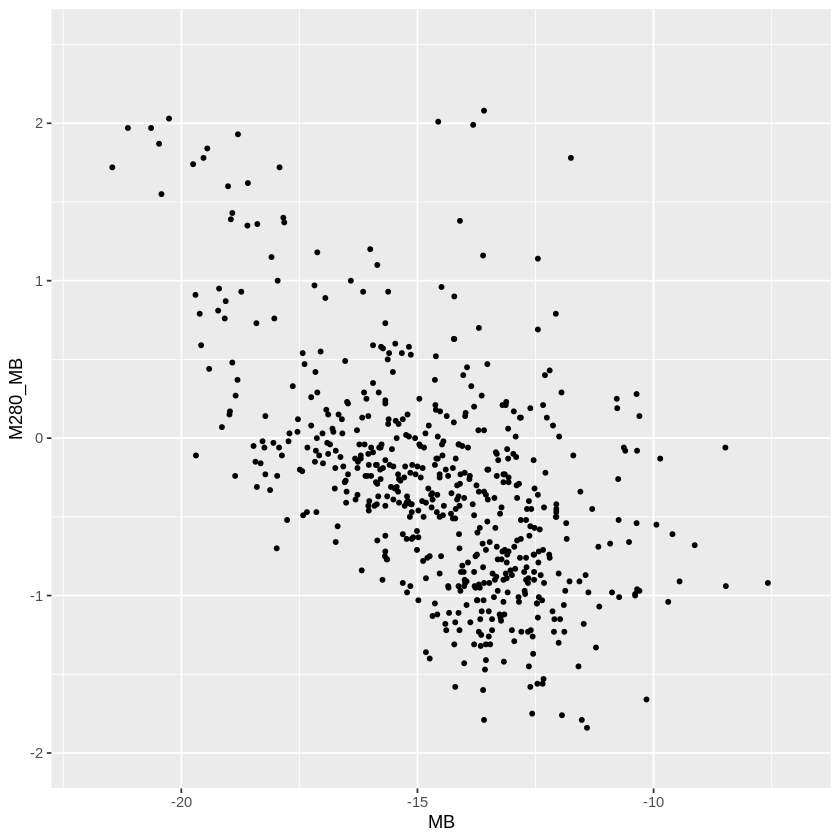

In [5]:
p <- ggplot(COMBO_loz, aes(x=MB, y=M280_MB))+
    geom_point(size=1) +
    xlim(-22,-7) + ylim(-2,2.5) +
    theme(aspect.ratio = 1)

p


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




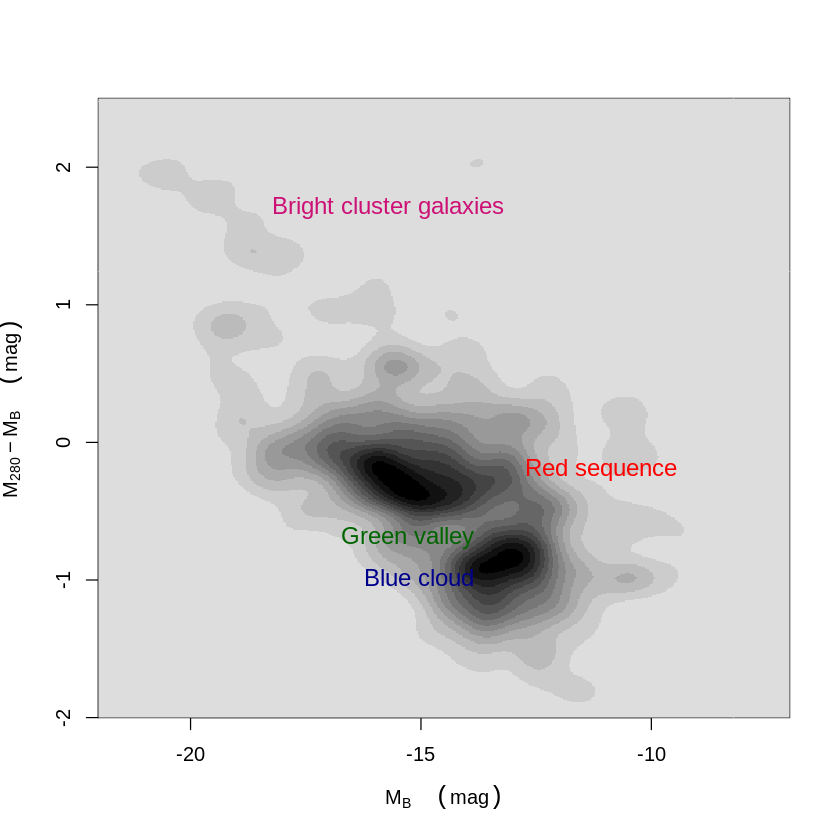

In [6]:
# Two-dimensional kernel-density estimator
# plot below from the author (subect matter expert who provided the labels)
library(MASS)
COMBO_loz_sm <- kde2d(COMBO_loz[,1], COMBO_loz[,2], h=c(1.6,0.4), 
   lims = c(-22,-7,-2,2.5), n=500)
image(COMBO_loz_sm, col=grey(13:0/15), xlab=expression(M[B]~~(mag)), 
   ylab=expression(M[280] - M[B]~~(mag)), xlim=c(-22,-7), ylim=c(-2,2.5), 
   xaxp=c(-20,-10,2))
text(-16.5, -1, "Blue cloud", col='darkblue', pos=4, cex=1.2)
text(-17,-0.7, 'Green valley', col='darkgreen', pos=4, cex=1.2)
text(-13, -0.2, 'Red sequence', col='red', pos=4, cex=1.2)
text(-18.5, 1.7, 'Bright cluster galaxies', col='deeppink3', pos=4, cex=1.2)

In [7]:
text_df <- data.frame(rbind(c(-16.5, -1, "Blue cloud", color='blue'),
            c(-17,-0.7, 'Green valley', color='green'),
            c(-13, -0.2, 'Red sequence', color='red'),
            c(-18.5, 1.7, 'Bright cluster galaxies', color='orange')))
names(text_df) <- c("MB","M280_MB","Name","Color")
text_df$MB <- as.numeric(text_df$MB)
text_df$M280_MB <- as.numeric(text_df$M280_MB)

Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”


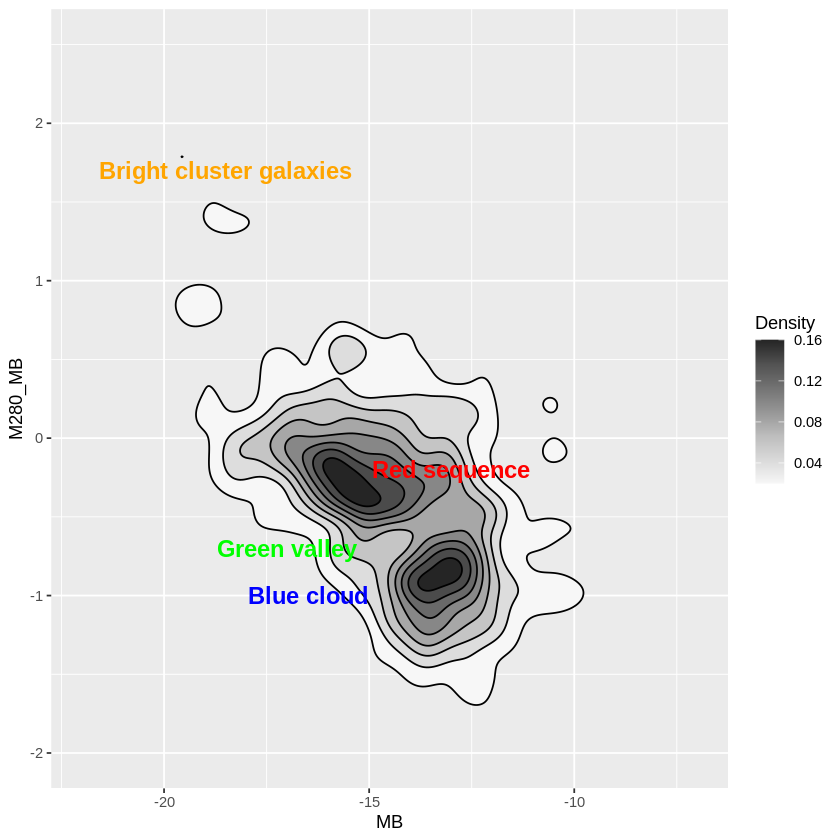

In [8]:
#do the above plot in ggplot
densplot <- COMBO_loz %>%
    ggplot(aes(x=MB, y=M280_MB))+
    stat_density_2d( geom = "density_2d_filled", contour = TRUE, n=500,h=c(1.6,0.4),
                  aes(fill = after_stat(level)), colour = "black") +
  scale_fill_distiller(palette = "Greys", direction = 1)+ 
    xlim(-22,-7) + ylim(-2,2.5)+
    geom_text(data=text_df, aes(label=Name) , color=text_df$Color,
            fontface='bold', size=5)+
    labs(fill="Density")
densplot

Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”


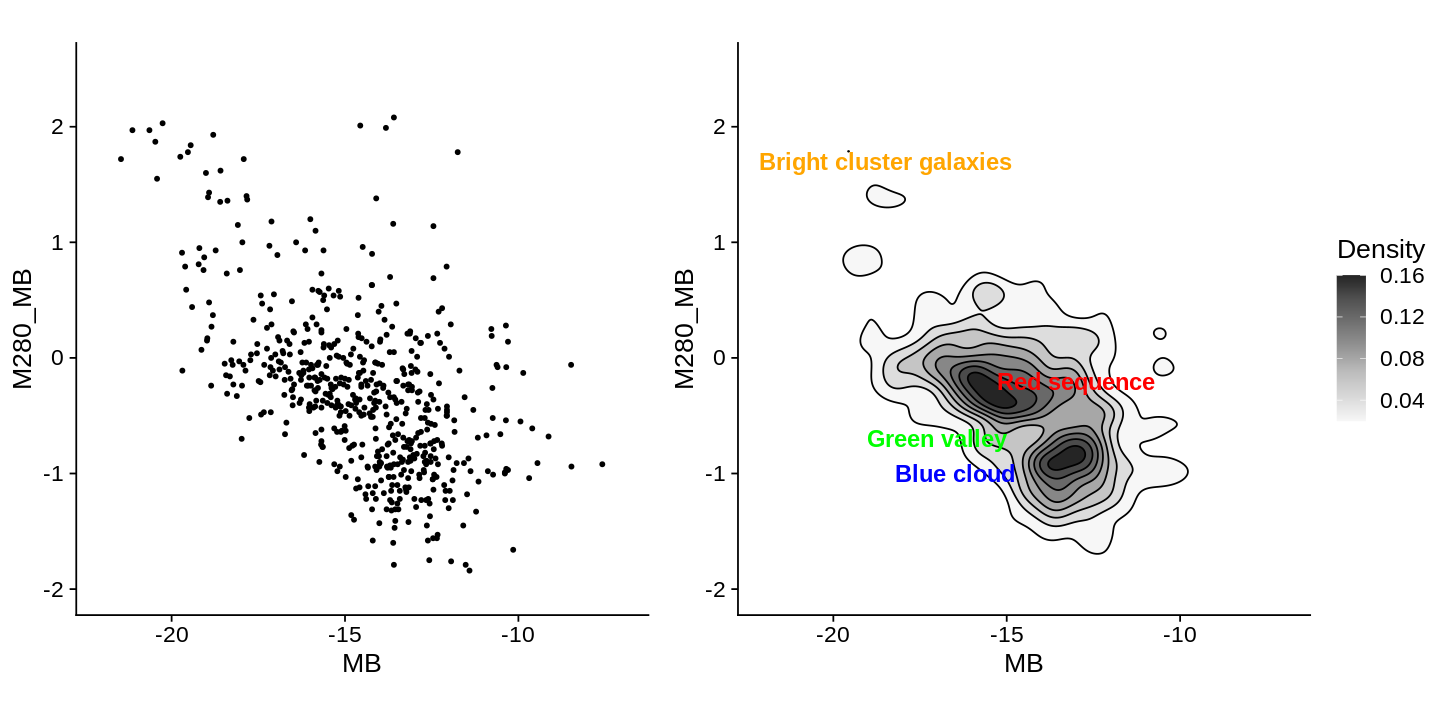

In [9]:
#set up some ggplot defaults
options(repr.plot.width=12, repr.plot.height=6)
oldtheme <- theme_set(theme_cowplot(font_size=16)+theme(aspect.ratio=1))

library(grid)
grid.draw(cbind(ggplotGrob(p), ggplotGrob(densplot), size = "last"))

## Standardize Data and Compute Distances

Last week, we showed that the `scale` function standardizes a variable represented as a vector.  We also showed that the `dist` function computes pairwise Euclidean (default) distance between pairs of rows in a dataframe. The result comes back as a lower triangular matrix.

It is this distance matrix that we'll use for our subsequent clustering explorations.

In [10]:
# Standardize variables and compute a Euclidean distance matrix

Mag_std <- scale(COMBO_loz[,1]) 
Color_std <- scale(COMBO_loz[,2])
COMBO_std <- cbind(Mag_std,Color_std)
COMBO_dist <- dist(COMBO_std)

## Density-Based Spatial Clustering with Noise (DBSCAN)

In [11]:
# Density-based clustering algorithm

# install.packages('fpc')
library(fpc)
COMBO_dbs <-  dbscan(COMBO_std, eps=0.1, MinPts=5, method='raw')
print.dbscan(COMBO_dbs) ; COMBO_dbs$cluster

dbscan Pts=572 MinPts=5 eps=0.1
         0  1  2  3 4 5 6 7 8 9 10 11 12 13 14 15 16
border 333 12 17 12 3 3 4 4 4 4  2  4  6  3  4  4  4
seed     0 59 46 16 6 2 2 1 1 4  4  1  2  2  1  1  1
total  333 71 63 28 9 5 6 5 5 8  6  5  8  5  5  5  5


[1]  0  0  0 15  0  0  6  1  1  0  0  2  0  2  0  3  4  2  3  0  0  1  0  0  0
 [26]  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  1  5  0  0  0  2  8  6  2  0
 [51]  7  0  8  0  0  0  0 14  0  0  9  0  3  0  0  1  1  1  0  0  0  1  0  0  3
 [76]  1  0  0 12  2  6  2  0  0  0  7  0  0 16  0  0  1  1  0  0  0  0  0  2  1
[101]  3 10  4  2  2  0  0  0  1  0  0  7  9  2  0  0  3  3  0  0  1  2  0  0  1
[126]  0  0  7  0  9  0  0  0  1  1  0  0 15 11  0 12  0  0  1  0  5  0  0  0  0
[151]  0  0  2  2 13  2 16 10  2  0  0  0  0  1  0  0  0  0  0  2  0  0  3  0 16
[176]  2  0  2  0  1  0  0  0  1  1  3  2  0  0  4  0  0  2  0  0  0  2  2  0  0
[201]  0  0 15  0  1  0  0  0  0 14  0 13  9  2  2  0  0  0  1  0  8  0  0  2  0
[226]  0  5  1  0  0  0  0  0  0 12  0  2  0  0  0  2  1  0  0  3  2  0  3  2  0
[251]  1  1  3  0  0  2  1  0  2 10  0  0  0 12  0  1  9  2  0  0  2  0  0  0  0
[276]  2  0  2  2  0  3  0  0  0  0  0  1  0  2  0  0  3  0  1  0  0  0  0  0  0
[301]  0  2  0  0 13  4  1  0  3  0  0  2 11  0  0  0  1  4  1  0  0  0  2  0  5
[326]  2  5  4  2  0  0  0  3  1  2 11 10  0  0 11  1 14  0  6  3  0  2  3  0  0
[351] 15  0  0  0  2  0  1  3  0  2  0  1  0  1  0  1  4  0  3  9  0  0  0  9  0
[376]  0  2  1  6  2  0  0  1  0  0  0  0  0 12  0  7  0  0  0  1  1  0  0  1  2
[401]  1  9  0  1  0  0  0  3  1  1  1  0  0  0  0  0  1  0  0  3  0 13  0  0  0
[426]  0  0  0  1  0  0  0  3 10  0  0  2  0  3  0  0  0 10  1  1  0  0  1  0  2
[451]  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  2  0  1 16 14  0  0  1  0  0
[476]  0  2  0  0  1  1  2 12  0  0  1  0  0  0  0  0 15  0  3  4  0  0  0  0  1
[501]  0  3  0  0  0  0  0 13  0  0  0  0  2  0  0  1  0  0  2  0  0  0 12  0  2
[526]  0  1  4  0  2  0  0  1  2 11  6  0  1 14  0  0  0  0  3  0 16  0  0  0  2
[551]  0  0  0  1  0  0  1  0  0  0  0  3  0  8  0  1  8  0  2  2  0  0

`dbscan` identified 16 clusters in addition to a background or noise cluster (cluster #0), cluster assignments shown above. `eps` parameter is shorthand for epsilon - which is the granularity of the kernel density function fitted over the data.

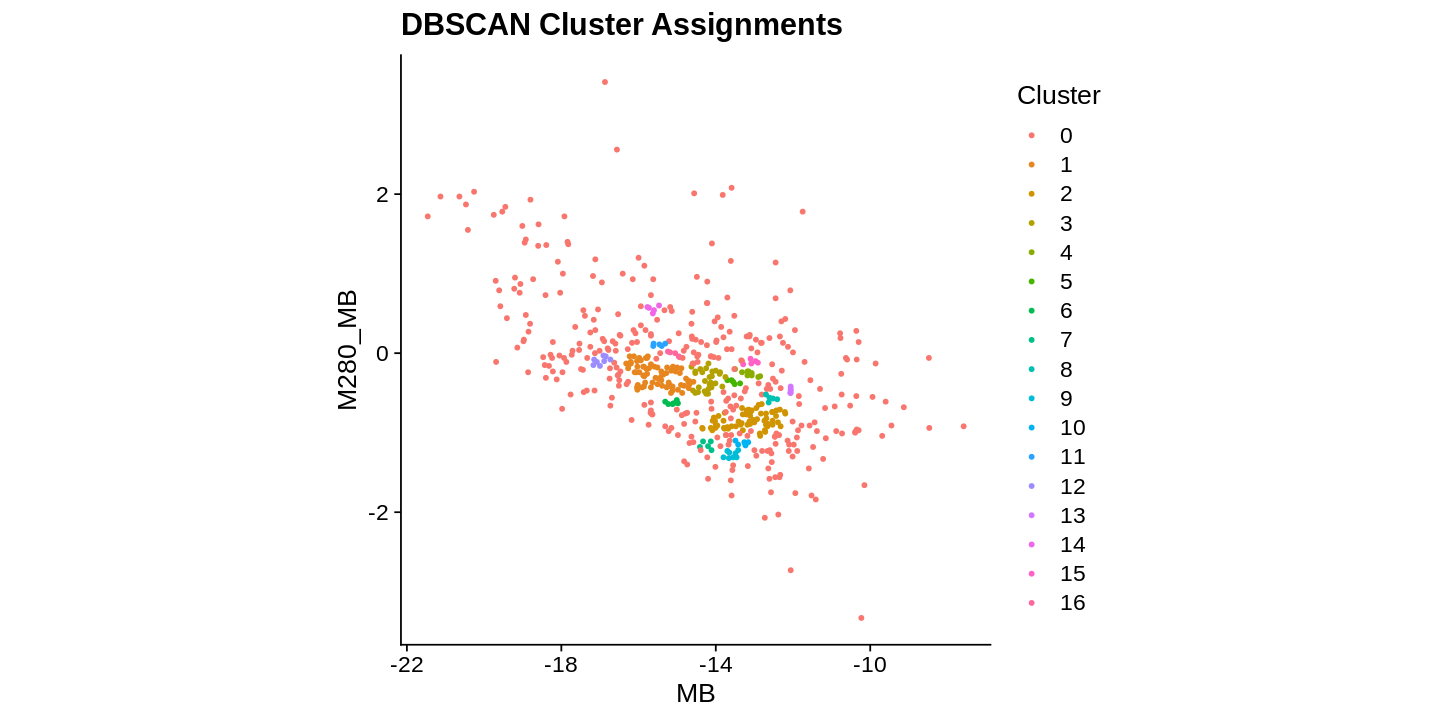

In [12]:
# what cluster assignments did we get?
p <- ggplot(data = COMBO_loz, aes(x=MB, y=M280_MB, color=as.factor(COMBO_dbs$cluster) ))+
    geom_point(size=1)+labs(title='DBSCAN Cluster Assignments', color='Cluster')
p




Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


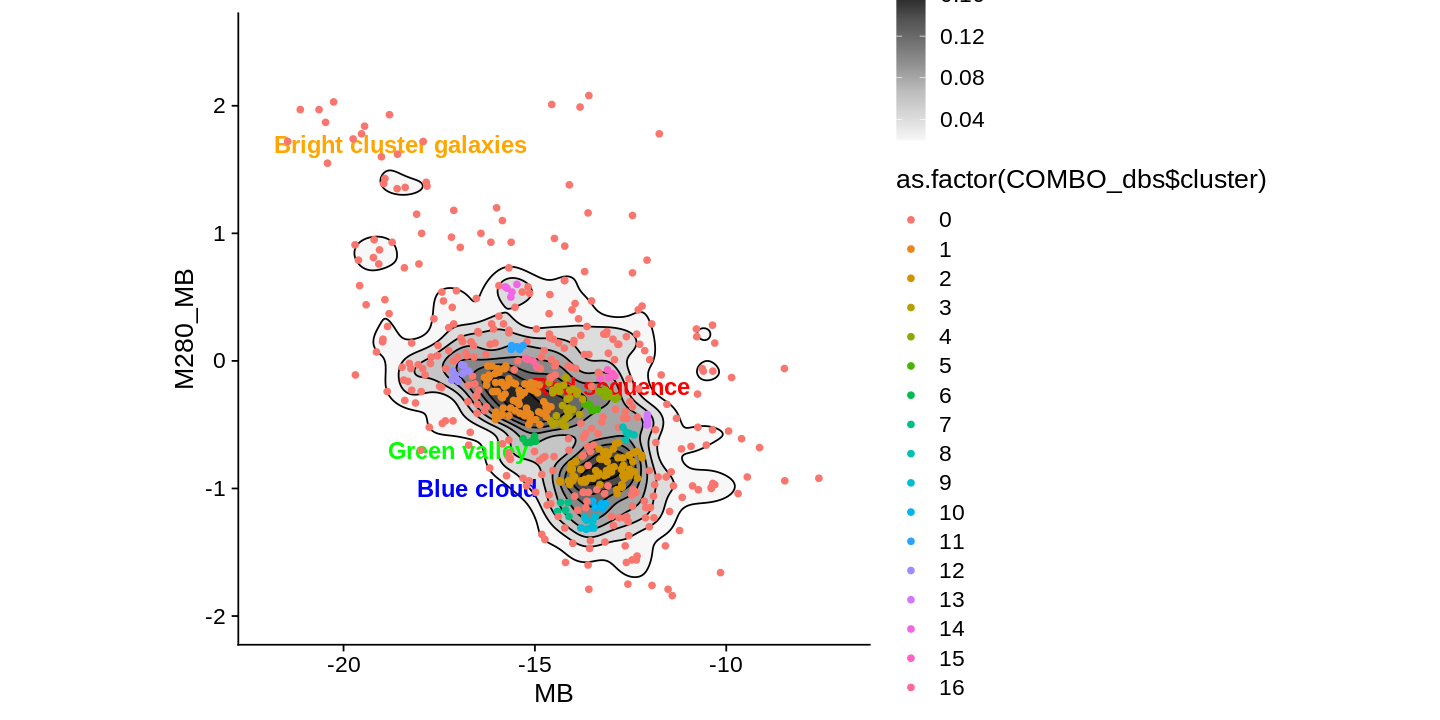

In [13]:
q <- densplot +
    geom_point(data = COMBO_loz, aes(x=MB, y=M280_MB, color=as.factor(COMBO_dbs$cluster) ))
q

In [14]:
print.dbscan(COMBO_dbs) 

dbscan Pts=572 MinPts=5 eps=0.1
         0  1  2  3 4 5 6 7 8 9 10 11 12 13 14 15 16
border 333 12 17 12 3 3 4 4 4 4  2  4  6  3  4  4  4
seed     0 59 46 16 6 2 2 1 1 4  4  1  2  2  1  1  1
total  333 71 63 28 9 5 6 5 5 8  6  5  8  5  5  5  5


In [15]:
# ditch the background and low population clusters
member_counts <- data.frame(Cluster=as.factor(COMBO_dbs$cluster)) %>%
  group_by(Cluster) %>% summarise(Count=n())

#find the cluster id's of the clusters with fewer than 8 members
small_pop <- member_counts$Cluster[member_counts$Count < 8]

#take the reverse to get the members with large populations
big_clusters <- member_counts[-as.integer(small_pop),]$Cluster

#fix up the cluster membership
#map the small pop clusters to 0 (background) which we'll later exclude
cluster_id <- ifelse(COMBO_dbs$cluster %in% big_clusters, COMBO_dbs$cluster,0)

#tack on the fixed-up member_id onto our data frame and exclude the background
q <- COMBO_loz %>% mutate(cluster_id=cluster_id)%>%
  filter(cluster_id > 0)

Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”


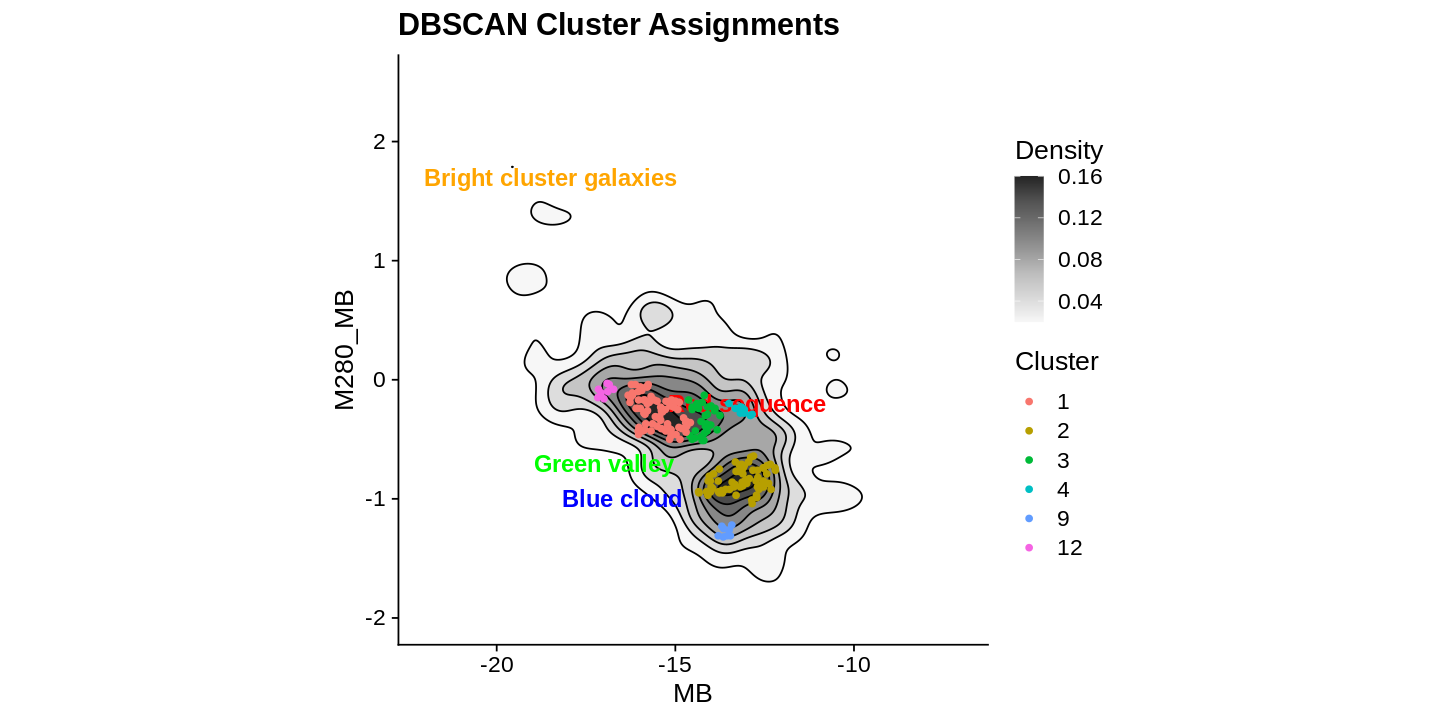

In [16]:
#plot it all out
densplot+  geom_point(data=q, aes(x=MB, y=M280_MB, color=as.factor(cluster_id) ))+
    labs(title='DBSCAN Cluster Assignments', color='Cluster')


## Varying `eps` Values

In [17]:
#scan over different eps values
eps_val <- c(0.08, 0.10, 0.12, 0.14,0.16, 0.18)
eps_scans <- list()
COMBO_loz_dbscan = COMBO_loz[c('MB','M280_MB')]
for (e in eps_val){
    eps_str <-  paste("eps value:",e)
    
    #do a dbscan for each eps value and save the result in a list
    eps_scans[[eps_str]] <-  dbscan(COMBO_std, eps=e, MinPts=8, method='raw')

    #tack on a cluster membership column for each eps value
    COMBO_loz_dbscan[eps_str] <- eps_scans[[eps_str]]$cluster
}

In [18]:
#turn the results into something that ggplot can deal with
eps_scans_df <- COMBO_loz_dbscan %>% gather(key="eps", value="Member.id", paste("eps value:",eps_val))

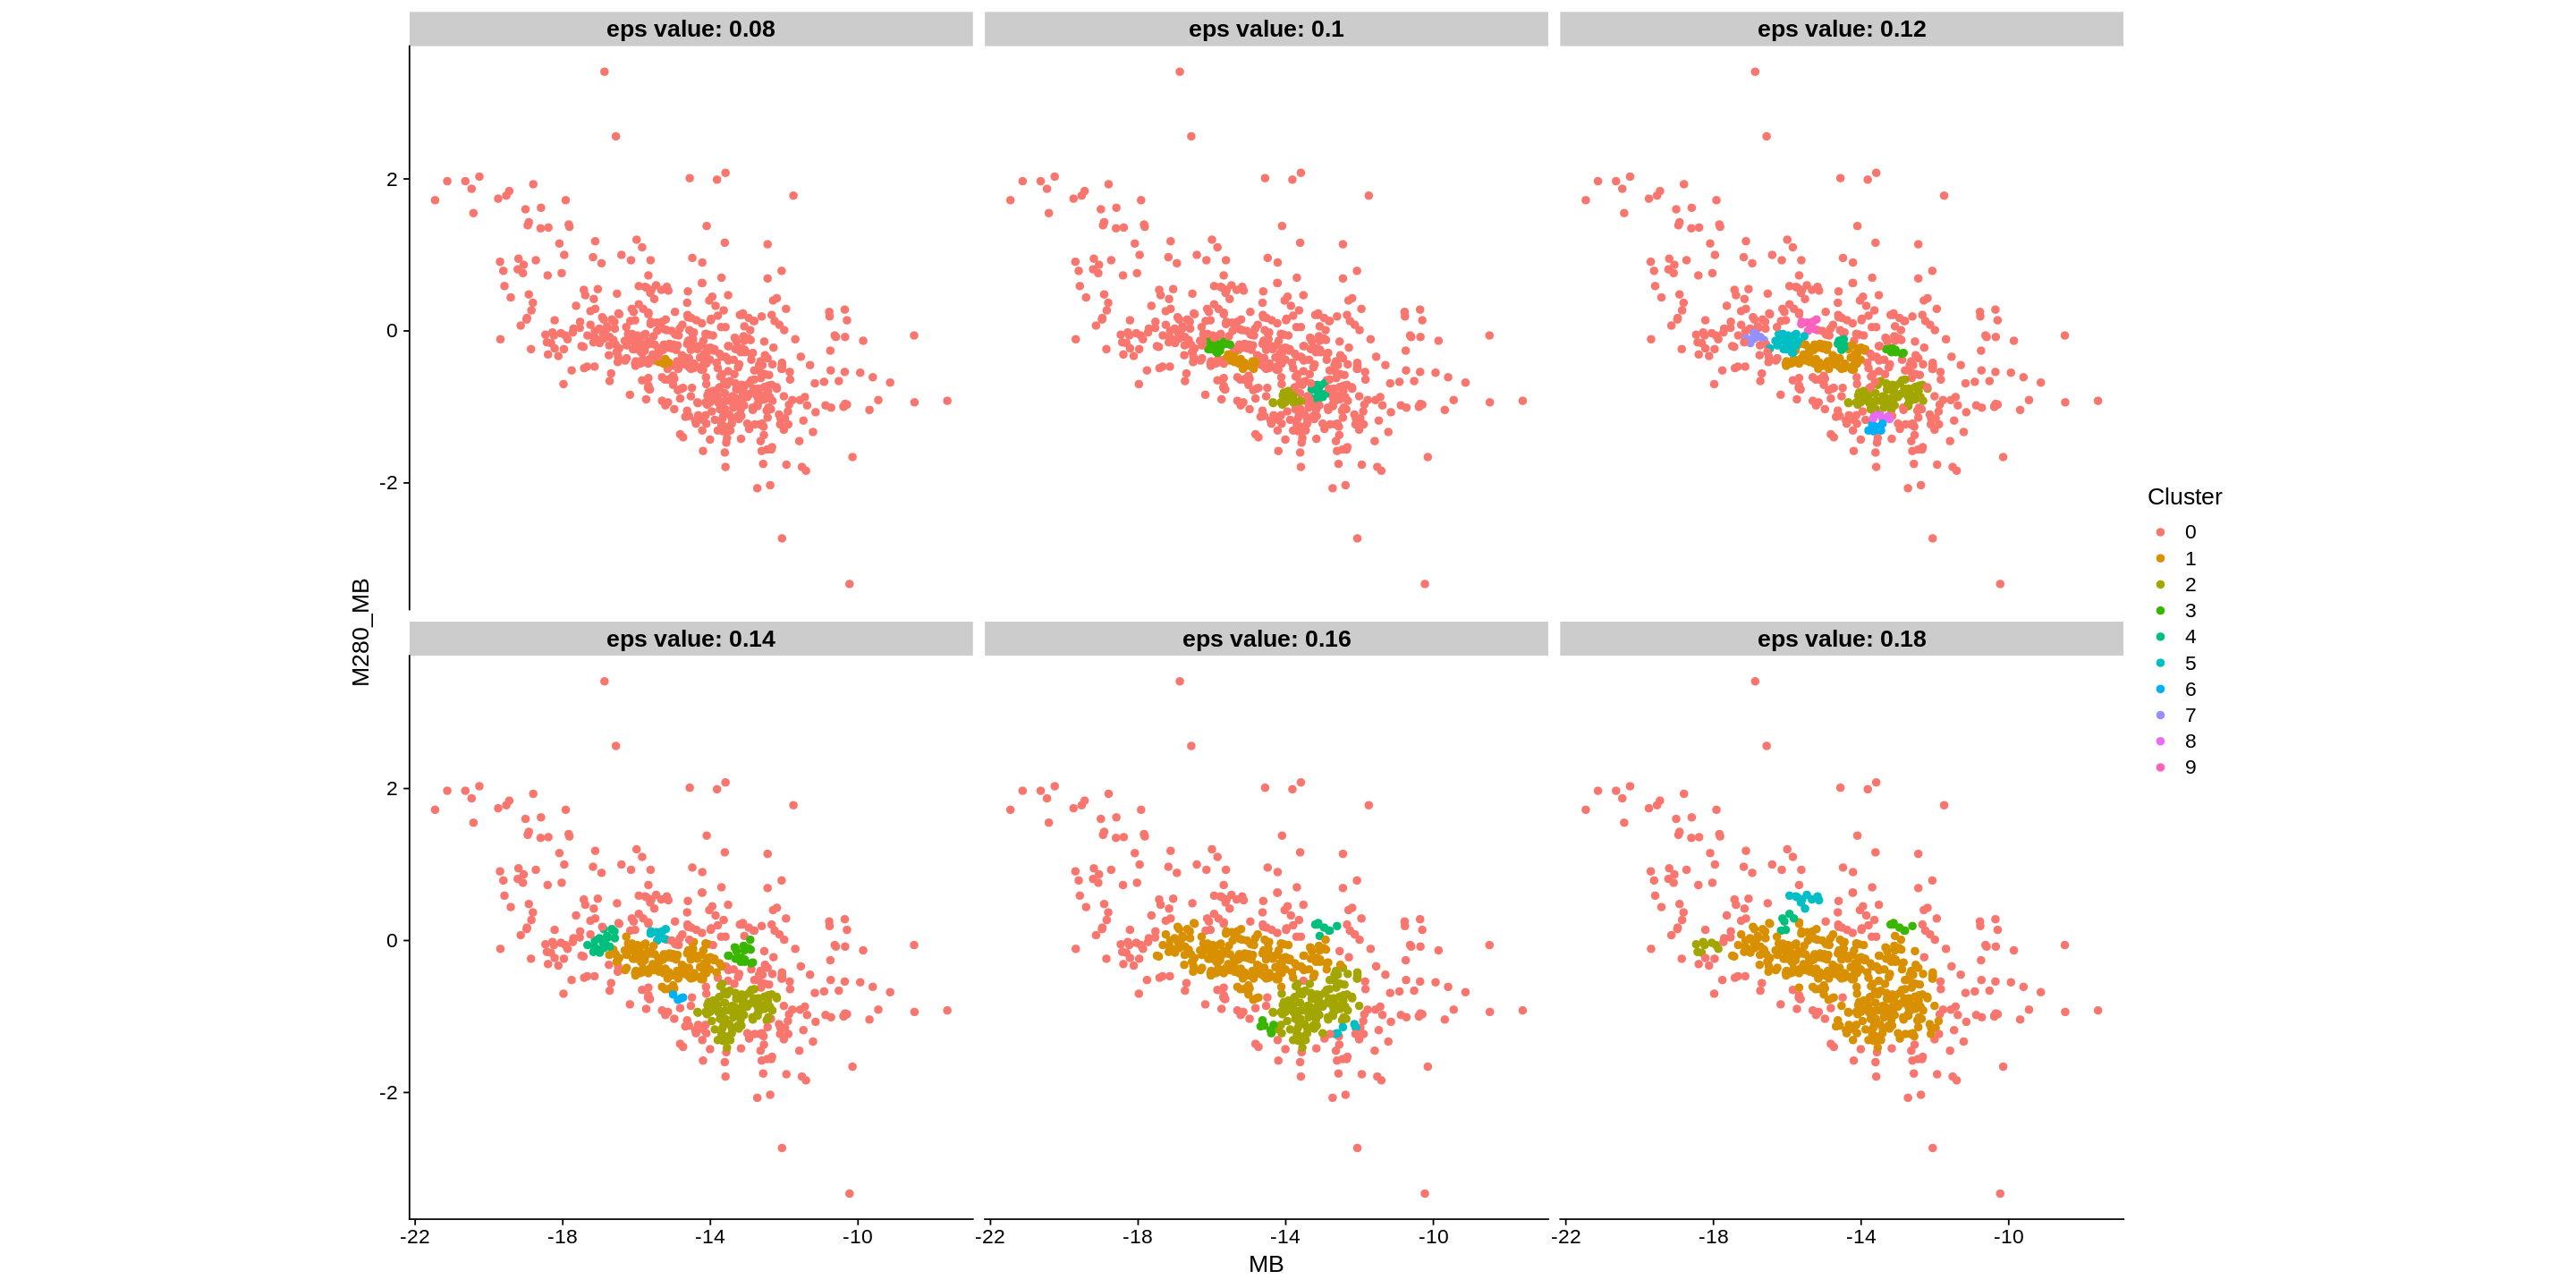

In [19]:
options(repr.plot.width=24, repr.plot.height=12)
eps_scans_df %>%
    ggplot(aes(x=MB, y=M280_MB, color=as.factor(Member.id)) ) +
    geom_point(data=eps_scans_df,aes(x=MB, y=M280_MB, color=as.factor(Member.id)), size=2)+
    labs(color='Cluster') +
    facet_wrap(~ eps) +
    theme(strip.text.x = element_text(size=16, face="bold"))

In [20]:
dp_notext <- COMBO_loz %>%
    ggplot(aes(x=MB, y=M280_MB))+
    stat_density_2d( geom = "density_2d_filled", contour = TRUE, n=500,h=c(1.6,0.4),
                  aes(fill = after_stat(level)), colour = "black") +
  scale_fill_distiller(palette = "Greys", direction = 1)+ 
    xlim(-22,-7) + ylim(-2,2.5)+
    labs(fill="Density")

Warning message:
“Removed 36 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 36 rows containing missing values (geom_point).”


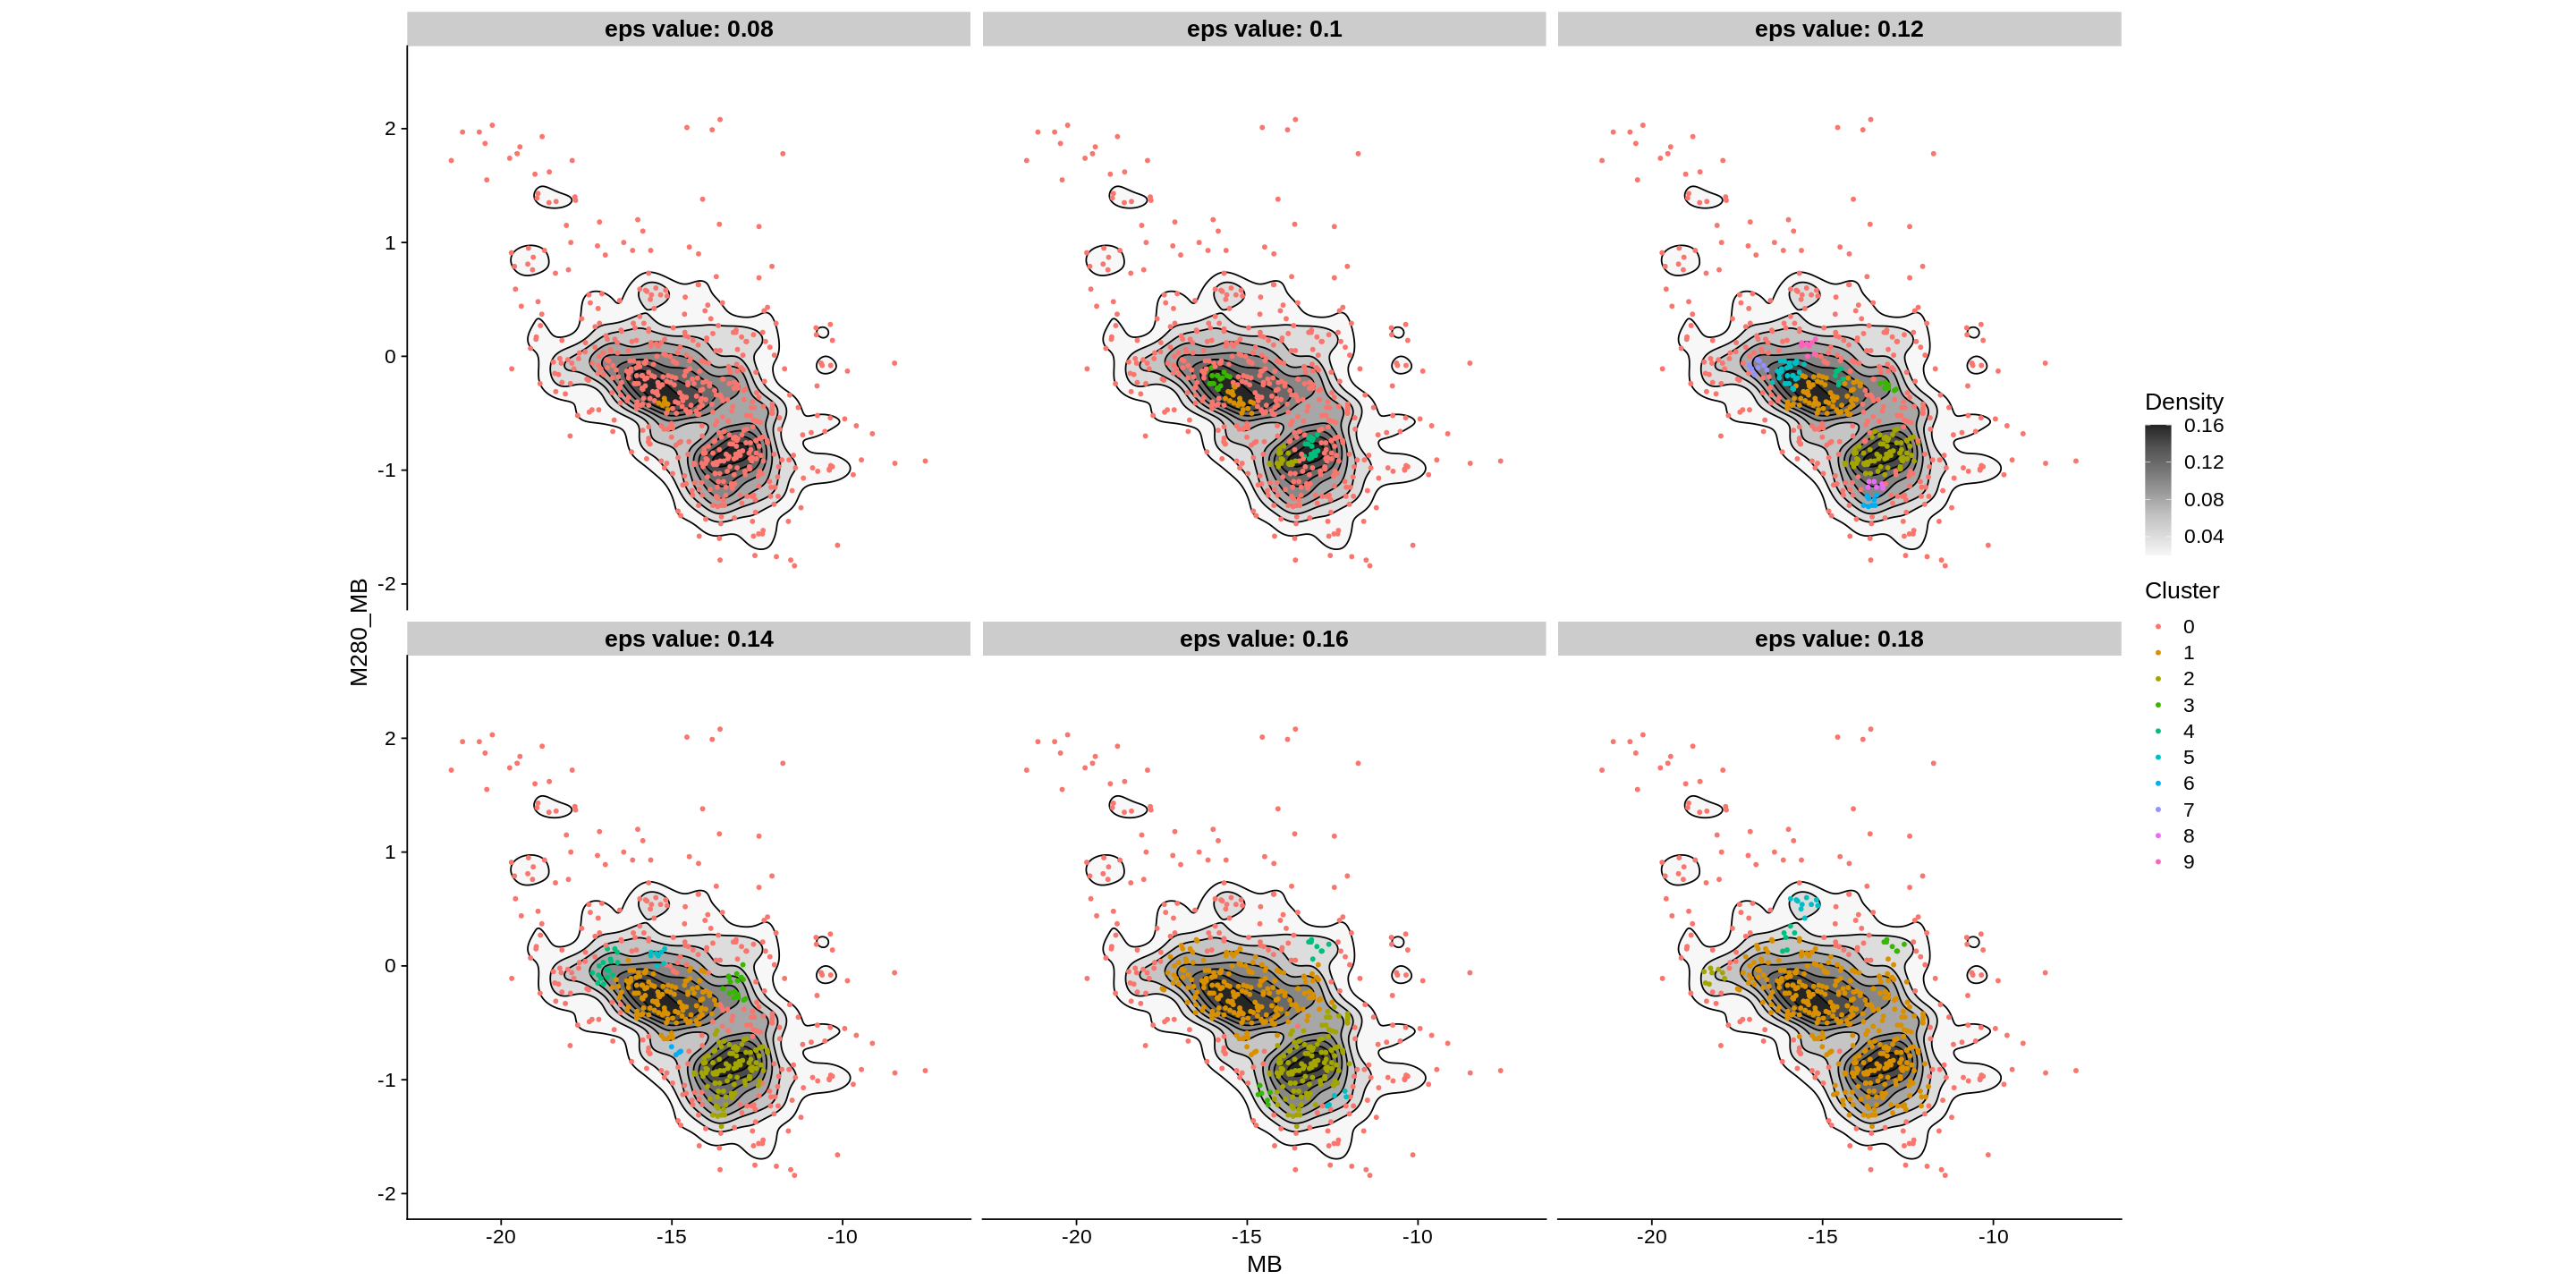

In [21]:
options(repr.plot.width=24, repr.plot.height=12)

dp_notext +
    geom_point(inherit.aes=FALSE, data=eps_scans_df,aes(x=MB, y=M280_MB, color=as.factor(Member.id)), size=1)+
    labs(color='Cluster') +
    facet_wrap(~ eps) +
    theme(strip.text.x = element_text(size=16, face="bold"))

Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”


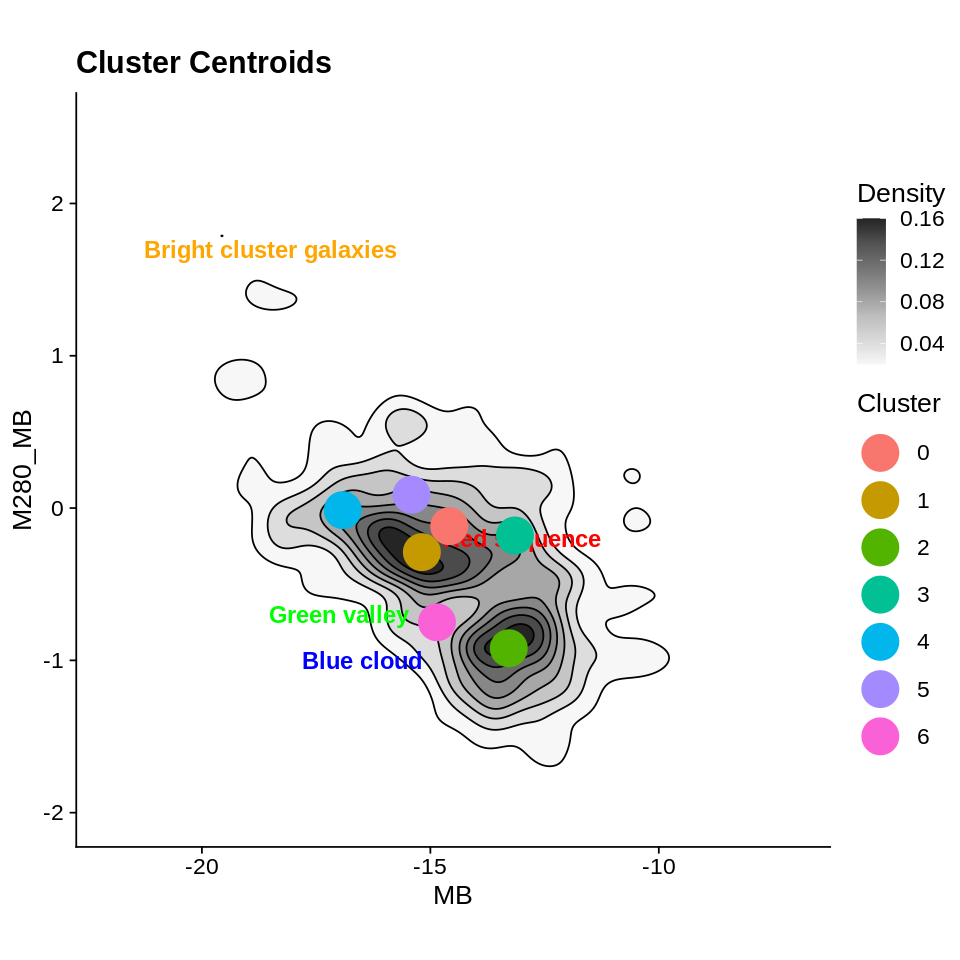

In [22]:
#clusters014 = eps_scans$`eps value: 0.14`$cluster
#clusters014
means_014 <- COMBO_loz_dbscan %>%
    dplyr::select(MB, M280_MB, `eps value: 0.14`) %>%
    mutate(cluster = as.factor(`eps value: 0.14`)) %>%
    group_by(cluster) %>%
    summarize(MB=mean(MB), M280_MB=mean(M280_MB))

options(repr.plot.width=8, repr.plot.height=8)
densplot +
    geom_point(data=means_014,aes(x=MB, y=M280_MB, color=cluster), size=10)+
    labs(color='Cluster', title='Cluster Centroids')


Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


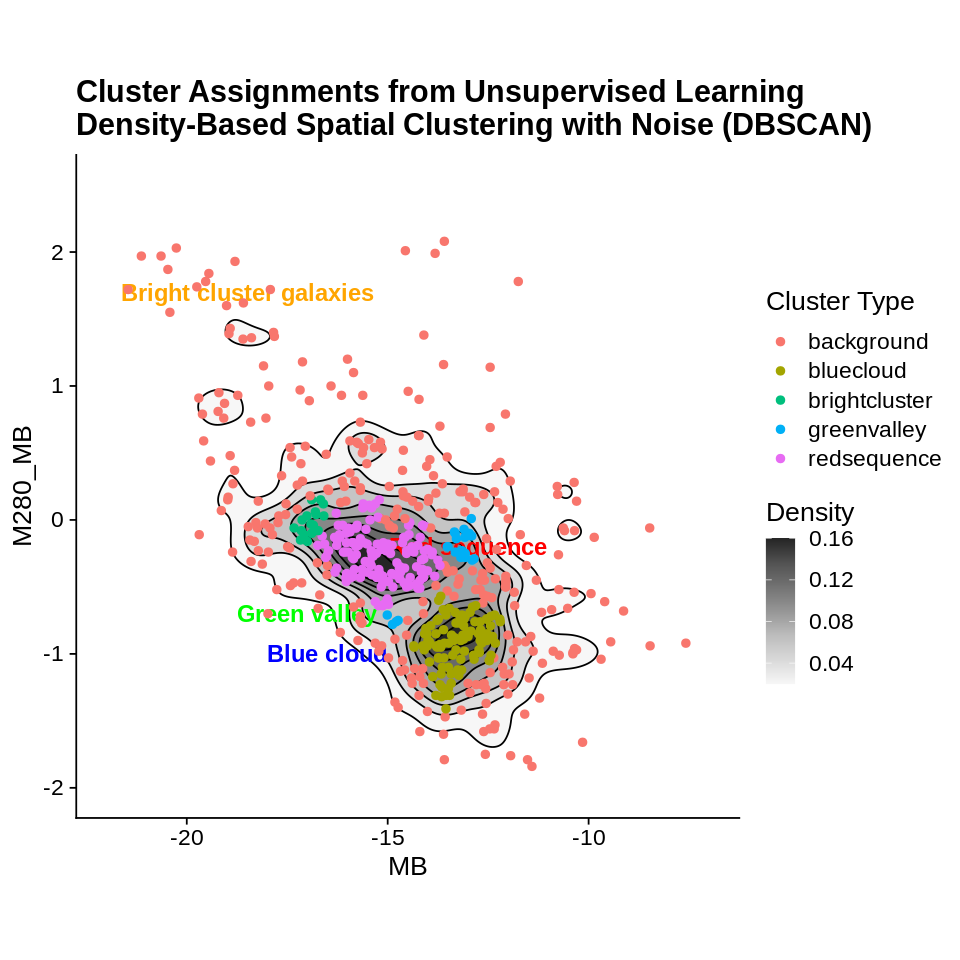

In [23]:
# consolidate the clusters to get the ones we want
cluster_mapper = c('background', 'redsequence', 'bluecloud', 'greenvalley','brightcluster','redsequence','greenvalley')
# need to +1 because cluster_ids start at 0, but array indexes start at 1
consol_clust = as.factor(cluster_mapper[as.integer(COMBO_loz_dbscan$`eps value: 0.14`)+1])

options(repr.plot.width=8, repr.plot.height=8)
p <- densplot +
    geom_point(data=COMBO_loz_dbscan,aes(x=MB, y=M280_MB,
                                 color=consol_clust), size=2)+
    labs(color="Cluster Type",
     title='Cluster Assignments from Unsupervised Learning\nDensity-Based Spatial Clustering with Noise (DBSCAN)' )
p

Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 6 rows containing non-finite values (stat_density2d).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


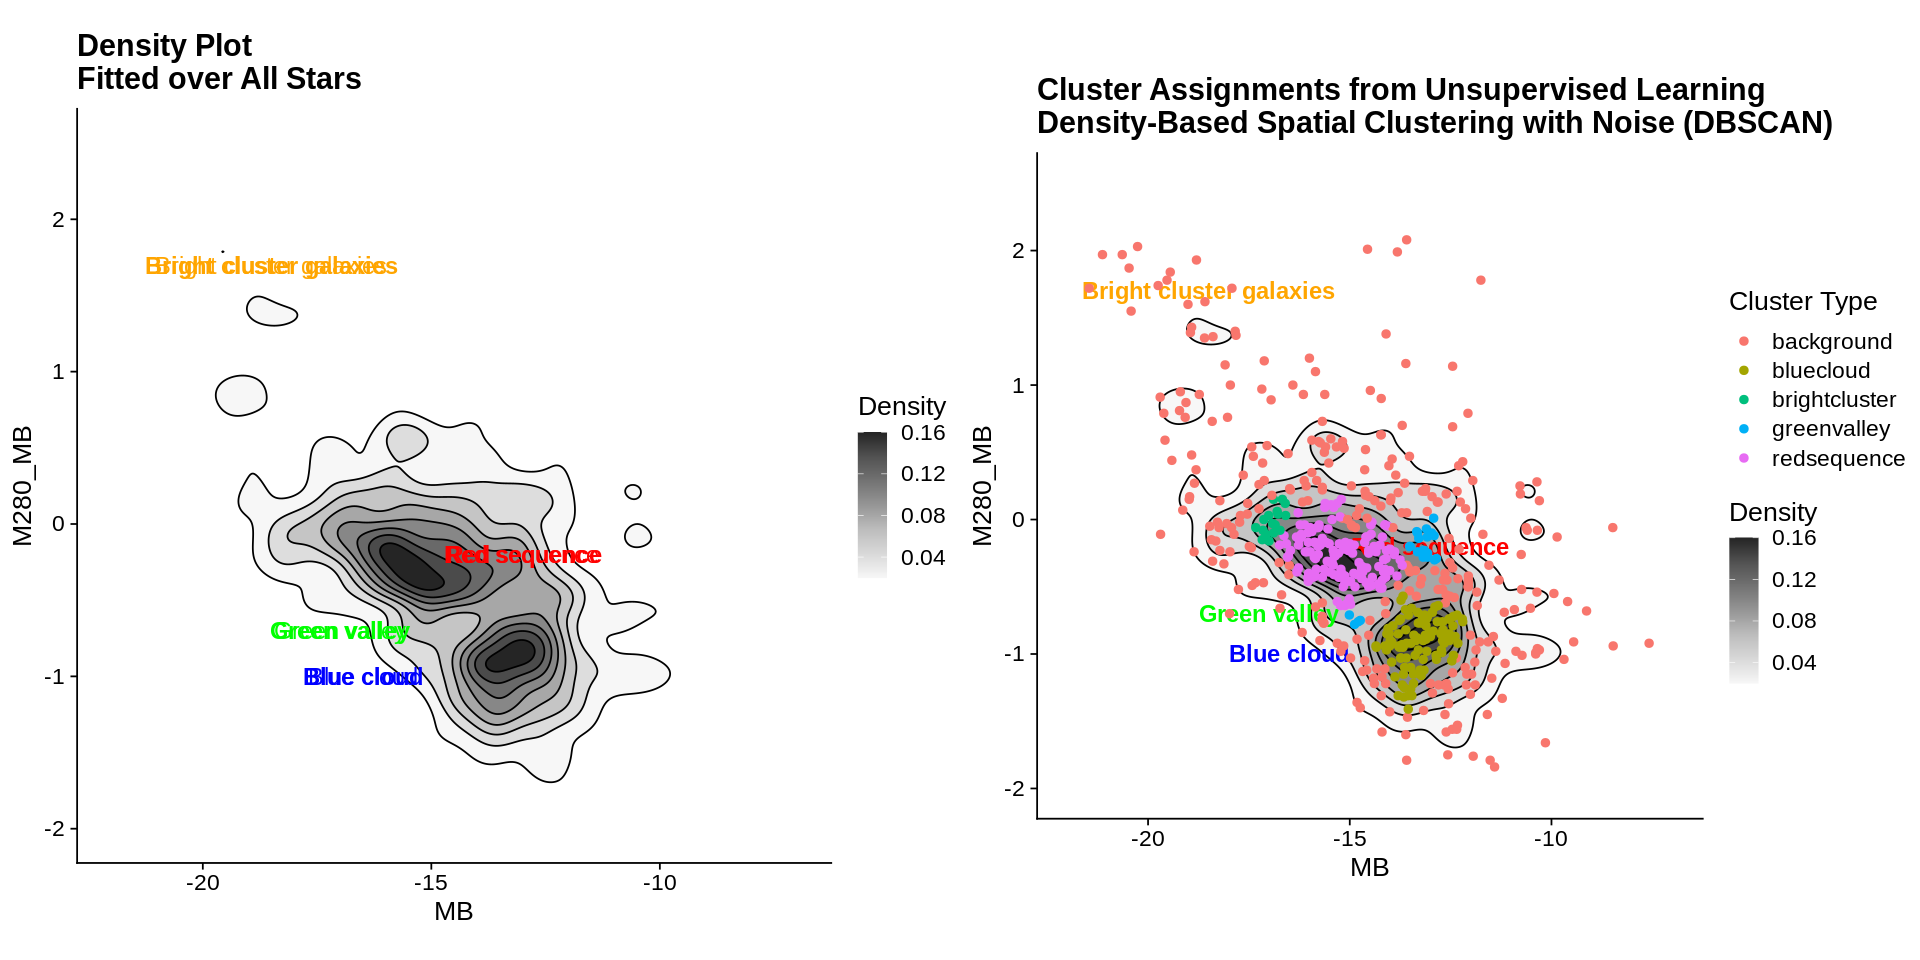

In [24]:
options(repr.plot.width=16, repr.plot.height=8)
cowplot::plot_grid(densplot +
geom_text(data=text_df, aes(label=Name) , color=text_df$Color, size=5)+labs(title='Density Plot\nFitted over All Stars'), p)


## Conclusions

It took a lot of parameter tweaking and consolidating and mapping of cluster assignments to get the results we wanted. So not very useful for this particular application.

Perhaps the problem in this case is that we knew *a priori* what the regions of color-magnitude diagram ought to be. We tried to use `dbscan` to automatically label the galaxies by which region of the CMD they in.

It would have been better to define polygons describing the regions and then assign a label based on which polygon each point fell into.

This application of `dbscan` would have been more useful as an exploratory tool, without the *a priori* knowledge that we had.  For example, what are the astrophysical properties of the members that cause them to fall into one group or another (the big dot plot above).